# Feature Engineering with Fast cuDF-Pandas!
One of the most powerful feature engineering techniques is `groupby(COL1)[COL2].agg(STAT)`. This is where we group by `COL1` column and aggregate (i.e. compute) a statistic `STAT` over another column `COL2`. This is the underlying method to compute `target encoding` and `count encoding`. By computing raw statistics and inputting them into our model, our model can do more than only receiving `TE` or `CE`. This notebook illustrates creating 50 engineered features, but we can create hundreds more and improve CV score and LB score!

When our dataset has millions of rows like Kaggle's Backpack competition, then `groupby` operations take time to compute. The fastest way to compute a `groupby` aggregation is to use GPU with [RAPIDS cuDF-Pandas][1] library.

There are two ways to use [RAPIDS cuDF][2]. We can write cuDF code which looks just like Pandas code and starts with `import cudf`. Or we can write normal Pandas code with `import pandas` but before that we add the cell magic command `%load_ext cudf.pandas`. By adding this magic command all calls to Pandas afterward will use [RAPIDS cuDF][2] behind the scenes taking advantage of the massive speed boost of GPU!

Alternatively, we can use [cuDF-Polars][3]. To use [cuDF-Polars][3], we write Polars code with lazy frame. Then the final call includes `.collect(engine="gpu")` which will run all previous Polars code behind the scenes with [RAPIDS cuDF][2].

[1]: https://rapids.ai/cudf-pandas/
[2]: https://docs.rapids.ai/install/
[3]: https://rapids.ai/polars-gpu-engine/

# RAPIDS v25.02
[RAPIDS v25.02][1] was just released Feb 15, 2025! Instructions on installing RAPIDS is [here][1]. On Kaggle, the easiest way to pip install new libraries is to do it once in a `Utility Script` notebook. Then whenever we attach the `Utility Script` notebook to another Kaggle notebook, the second Kaggle notebook immediately gets the benefit of the pip installed libraries. We created a [RAPIDS 25.02][1] `Utility Script` [here][2], and we attach it to the notebook you are reading. Therefore the notebook you are reading can import RAPIDS v25.02 without needing to pip install!

[1]: https://docs.rapids.ai/install/
[2]: https://www.kaggle.com/code/cdeotte/rapids-cudf-25-02-cuml-25-02

# GPU Acceleration
We activate [cuDF-Pandas][1] with the magic command `%load_ext cudf.pandas` below. Afterward, all calls to Pandas will use fast GPU [RAPIDS cuDF][2] behind the scenes! Since we attached `Utility Script` notebook [here][3] to the notebook you are reading, we will be using the new [RAPIDS v25.02][2]!

[1]: https://rapids.ai/cudf-pandas/
[2]: https://docs.rapids.ai/install/
[3]: https://www.kaggle.com/code/cdeotte/rapids-cudf-25-02-cuml-25-02

In [1]:
%load_ext cudf.pandas

import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Load Data
We load train, train extra, and test data. The combined train data has 4 million rows! This means we do not need to fear overfitting train. We can make hundreds/thousands of new features and every time our CV improves our LB will improve too!

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
train_extra = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
train = pd.concat([train, train_extra], axis=0, ignore_index=True)

In [3]:
original_df = pd.read_csv("/kaggle/input/student-bag-price-prediction-dataset/Noisy_Student_Bag_Price_Prediction_Dataset.csv")
original_df = original_df.groupby("Weight Capacity (kg)").Price.mean()
original_df.name = "original_Price"
train = train.merge(original_df, on="Weight Capacity (kg)", how="left")
test = test.merge(original_df, on="Weight Capacity (kg)", how="left")

In [4]:
# merge features from original to train and test df's
original_df = pd.read_csv("/kaggle/input/student-bag-price-prediction-dataset/Noisy_Student_Bag_Price_Prediction_Dataset.csv")
original_df = original_df.loc[(original_df["Weight Capacity (kg)"]>5)&(original_df["Weight Capacity (kg)"]<30)]
original_df.columns = [f"original_{c}" for c in original_df.columns]
train = train.merge(original_df.iloc[:,:-1], left_on="Weight Capacity (kg)", right_on="original_Weight Capacity (kg)", how="left")
#train_df = train_df.drop("id",axis=1)
test = test.merge(original_df.iloc[:,:-1], left_on="Weight Capacity (kg)", right_on="original_Weight Capacity (kg)", how="left")
display(train.info(), test.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 21 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   Brand                          object
 2   Material                       object
 3   Size                           object
 4   Compartments                   float64
 5   Laptop Compartment             object
 6   Waterproof                     object
 7   Style                          object
 8   Color                          object
 9   Weight Capacity (kg)           float64
 10  Price                          float64
 11  original_Price                 float64
 12  original_Brand                 object
 13  original_Material              object
 14  original_Size                  object
 15  original_Compartments          float64
 16  original_Laptop Compartment    object
 17  original_Waterproof            object
 18  original_Style    

None

None

In [5]:
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from statsmodels.nonparametric.kde import KDEUnivariate

def analyze_dataset_noise(data, verbose=True):
    """
    Analyze a dataset to estimate noise levels and signal strength
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset to analyze
    verbose : bool
        Whether to print analysis results
        
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    results = {}
    
    # 1. Basic statistical analysis
    if verbose:
        print("1. BASIC STATISTICAL ANALYSIS")
        print("-" * 50)
    
    # Check for missing values
    missing_percent = data.isnull().mean() * 100
    results['missing_values'] = missing_percent
    
    if verbose:
        print(f"Missing values percentage per column:")
        for col, pct in missing_percent.items():
            print(f"  {col}: {pct:.2f}%")
        print()
    
    # Check for outliers using Z-score
    numeric_data = data.select_dtypes(include=[np.number]).dropna()
    if not numeric_data.empty:
        z_scores = stats.zscore(numeric_data, nan_policy='omit')
        outliers_z = (np.abs(z_scores) > 3).any(axis=1).sum()
        outlier_percent_z = outliers_z / len(data) * 100
        results['outliers_zscore_percent'] = outlier_percent_z
        
        if verbose:
            print(f"Potential outliers (Z-score > 3): {outliers_z} rows ({outlier_percent_z:.2f}%)")
            print()
    else:
        if verbose:
            print("No numeric data available for outlier analysis")
            print()
    
    # 2. Distribution analysis
    if verbose:
        print("2. DISTRIBUTION ANALYSIS")
        print("-" * 50)
    
    # Calculate skewness and kurtosis for numerical columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        dist_stats = pd.DataFrame({
            'skewness': data[numeric_cols].skew(),
            'kurtosis': data[numeric_cols].kurtosis()
        })
        results['distribution_stats'] = dist_stats
        
        if verbose:
            print("Distribution statistics (high absolute values may indicate noise or signal):")
            print(dist_stats)
            print()
    else:
        if verbose:
            print("No numeric data available for distribution analysis")
            print()
    
    # 3. Signal-to-noise estimation using PCA
    if verbose:
        print("3. SIGNAL-TO-NOISE ESTIMATION USING PCA")
        print("-" * 50)
    
    # Standardize data for PCA
    numeric_data = data.select_dtypes(include=[np.number]).dropna()
    if len(numeric_data) > 0 and len(numeric_data.columns) > 1:  # Need at least 2 columns for PCA
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(numeric_data)
        
        # Apply PCA
        pca = PCA()
        pca.fit(scaled_data)
        
        # Calculate explained variance ratio
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        # Estimate signal based on principal components
        # (Components that explain significant variance likely contain signal)
        n_components_90pct = np.argmax(cumulative_variance >= 0.9) + 1
        signal_ratio = sum(explained_variance[:n_components_90pct]) / sum(explained_variance)
        noise_ratio = 1 - signal_ratio
        
        results['pca_signal_ratio'] = signal_ratio
        results['pca_noise_ratio'] = noise_ratio
        results['pca_n_components_90pct'] = n_components_90pct
        results['pca_explained_variance'] = explained_variance
        
        if verbose:
            print(f"PCA Analysis Results:")
            print(f"  Estimated signal ratio: {signal_ratio:.2f} ({signal_ratio*100:.1f}%)")
            print(f"  Estimated noise ratio: {noise_ratio:.2f} ({noise_ratio*100:.1f}%)")
            print(f"  Number of components to explain 90% variance: {n_components_90pct}")
            print(f"  Variance explained by top 5 components: {explained_variance[:min(5, len(explained_variance))]}")
            print()
    else:
        if verbose:
            print("Not enough numeric data for PCA analysis (need at least 2 numeric columns)")
            print()
    
    # 4. Anomaly detection using Isolation Forest
    if verbose:
        print("4. ANOMALY DETECTION")
        print("-" * 50)
    
    if len(numeric_data) > 0 and len(numeric_data.columns) > 0:
        # Use Isolation Forest to identify anomalies (potential noise)
        try:
            if len(numeric_data.columns) > 1:
                # Multi-dimensional data
                iso_forest = IsolationForest(contamination=0.1, random_state=42)
                scaled_data = StandardScaler().fit_transform(numeric_data)
                outliers = iso_forest.fit_predict(scaled_data)
            else:
                # One-dimensional data
                iso_forest = IsolationForest(contamination=0.1, random_state=42)
                scaled_data = StandardScaler().fit_transform(numeric_data.values.reshape(-1, 1))
                outliers = iso_forest.fit_predict(scaled_data)
                
            outlier_count = (outliers == -1).sum()
            outlier_percent = outlier_count / len(numeric_data) * 100
            
            results['isolation_forest_outliers'] = outlier_count
            results['isolation_forest_outlier_percent'] = outlier_percent
            
            if verbose:
                print(f"Isolation Forest anomaly detection:")
                print(f"  Detected anomalies: {outlier_count} samples ({outlier_percent:.2f}%)")
                print()
        except Exception as e:
            if verbose:
                print(f"Error during anomaly detection: {str(e)}")
                print()
    else:
        if verbose:
            print("Not enough numeric data for anomaly detection")
            print()
    
    # 5. Feature correlation analysis
    if verbose:
        print("5. FEATURE CORRELATION ANALYSIS")
        print("-" * 50)
    
    # Calculate correlation matrix
    if len(numeric_data.columns) > 1:
        try:
            corr_matrix = numeric_data.corr()
            
            # Get average absolute correlation per feature
            # Fix: Check if corr_matrix is a DataFrame before using sort_values
            mean_corr = np.abs(corr_matrix).mean()
            if isinstance(mean_corr, pd.Series):
                avg_corr = mean_corr.sort_values(ascending=False)
            else:
                # For the case where mean_corr is a scalar (one column)
                avg_corr = mean_corr
                
            results['average_correlation'] = avg_corr
            
            if verbose:
                print("Average absolute correlation per feature (higher suggests stronger signal):")
                if isinstance(avg_corr, pd.Series):
                    for col, val in avg_corr.items():
                        print(f"  {col}: {val:.4f}")
                else:
                    print(f"  Single feature correlation: {avg_corr:.4f}")
                print()
        except Exception as e:
            if verbose:
                print(f"Error during correlation analysis: {str(e)}")
                print()
    else:
        if verbose:
            print("Not enough numeric columns for correlation analysis (need at least 2)")
            print()
    
    # Create summary of noise/signal indicators
    if verbose:
        print("SUMMARY")
        print("-" * 50)
        
        if 'pca_signal_ratio' in results:
            print(f"Estimated signal-to-noise ratio (PCA-based): {results['pca_signal_ratio']:.2f}:{results['pca_noise_ratio']:.2f}")
            print(f"Estimated signal percentage: {results['pca_signal_ratio']*100:.1f}%")
            print(f"Estimated noise percentage: {results['pca_noise_ratio']*100:.1f}%")
        
        if 'isolation_forest_outlier_percent' in results:
            print(f"Estimated noise from anomaly detection: {results['isolation_forest_outlier_percent']:.1f}%")
    
    return results

In [6]:
def plot_noise_analysis(data, results):
    """Plot visualizations of the noise analysis results"""
    # Set up the matplotlib figure
    fig = plt.figure(figsize=(15, 12))
    
    # Check if we have enough numeric data to plot
    numeric_data = data.select_dtypes(include=[np.number])
    if numeric_data.empty:
        plt.figtext(0.5, 0.5, "Not enough numeric data for visualization", 
                   ha="center", va="center", fontsize=14)
        plt.tight_layout()
        plt.show()
        return
    
    # Plot counter to track subplot positions
    plot_counter = 1
    
    # 1. PCA explained variance plot
    if 'pca_explained_variance' in results:
        ax1 = plt.subplot(2, 2, plot_counter)
        plot_counter += 1
        
        exp_var = results['pca_explained_variance']
        plt.bar(range(1, len(exp_var) + 1), exp_var, alpha=0.8, label='Individual explained variance')
        plt.step(range(1, len(exp_var) + 1), np.cumsum(exp_var), where='mid', label='Cumulative explained variance')
        plt.axhline(y=0.9, color='r', linestyle='-', alpha=0.5, label='90% threshold')
        plt.xlabel('Principal Components')
        plt.ylabel('Explained variance ratio')
        plt.title('PCA: Explained Variance by Components')
        plt.legend(loc='best')
    
    # 2. Distribution of numeric features
    if len(numeric_data.columns) > 0:
        ax2 = plt.subplot(2, 2, plot_counter)
        plot_counter += 1
        
        # Standardize data for comparison
        try:
            scaler = StandardScaler()
            scaled_data = pd.DataFrame(scaler.fit_transform(numeric_data), columns=numeric_data.columns)
            
            # Plot distribution of each numeric column
            for column in scaled_data.columns:
                sns.kdeplot(scaled_data[column], label=column)
            
            plt.xlabel('Standardized values')
            plt.ylabel('Density')
            plt.title('Distribution of Standardized Features')
            if len(scaled_data.columns) <= 10:  # Only show legend if not too many columns
                plt.legend()
        except Exception as e:
            plt.figtext(0.5, 0.5, f"Error plotting distributions: {str(e)}", 
                       ha="center", va="center", fontsize=10)
    
    # 3. Skewness and Kurtosis
    if 'distribution_stats' in results:
        ax4 = plt.subplot(2, 2, plot_counter)
        plot_counter += 1
        
        try:
            dist_stats = results['distribution_stats']
            dist_stats.plot(kind='bar', ax=ax4)
            plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
            plt.title('Skewness and Kurtosis by Feature')
            plt.ylabel('Value')
        except Exception as e:
            plt.figtext(0.5, 0.5, f"Error plotting distribution stats: {str(e)}", 
                       ha="center", va="center", fontsize=10)
    
    plt.tight_layout()
    plt.show()

1. BASIC STATISTICAL ANALYSIS
--------------------------------------------------
Missing values percentage per column:
  id: 0.00%
  Brand: 3.17%
  Material: 2.78%
  Size: 2.20%
  Compartments: 0.00%
  Laptop Compartment: 2.47%
  Waterproof: 2.36%
  Style: 2.61%
  Color: 3.35%
  Weight Capacity (kg): 0.05%
  Price: 0.00%
  original_Price: 61.80%
  original_Brand: 63.18%
  original_Material: 63.26%
  original_Size: 63.19%
  original_Compartments: 62.96%
  original_Laptop Compartment: 63.26%
  original_Waterproof: 63.25%
  original_Style: 63.20%
  original_Color: 63.23%
  original_Weight Capacity (kg): 61.30%

Potential outliers (Z-score > 3): 0 rows (0.00%)

2. DISTRIBUTION ANALYSIS
--------------------------------------------------
Distribution statistics (high absolute values may indicate noise or signal):
                               skewness  kurtosis
id                            -0.066548 -1.120073
Compartments                   0.033133 -1.240826
Weight Capacity (kg)          -

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

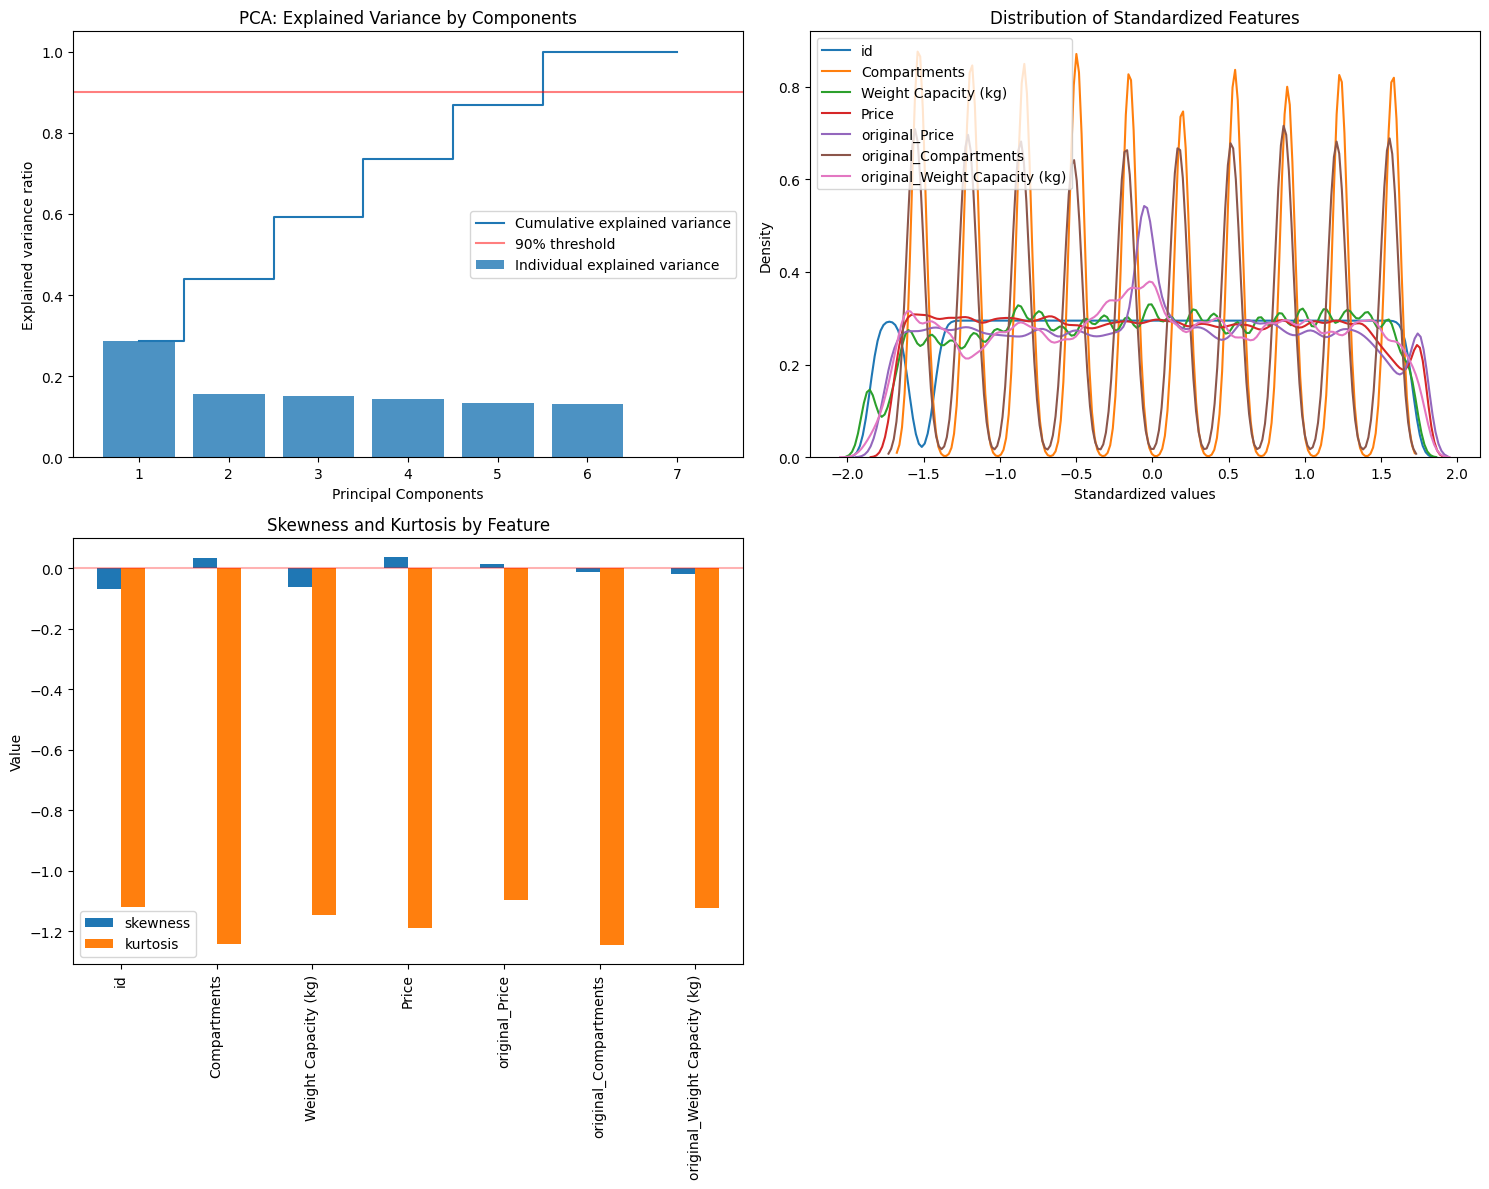

In [7]:
results = analyze_dataset_noise(train)
plot_noise_analysis(train, results)

# Feature Engineer Columns
We will engineer new columns by combining existing columns.

In [8]:
CATS = list(train.drop(columns=["Price", "id", "Weight Capacity (kg)", "original_Weight Capacity (kg)"]).columns)
print(f"There are {len(CATS)} categorical columns:")
print( CATS )
print(f"There are 2 numerical columns:")
print( ["Weight Capacity (kg)", "original_Weight Capacity (kg)"] )

There are 17 categorical columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'original_Price', 'original_Brand', 'original_Material', 'original_Size', 'original_Compartments', 'original_Laptop Compartment', 'original_Waterproof', 'original_Style', 'original_Color']
There are 2 numerical columns:
['Weight Capacity (kg)', 'original_Weight Capacity (kg)']


In [9]:
COMBO = []
for i,c in enumerate(CATS):
    #print(f"{c}, ",end="")
    combine = pd.concat([train[c],test[c]],axis=0)
    combine,_ = pd.factorize(combine)
    train[c] = combine[:len(train)]
    test[c] = combine[len(train):]
    n = f"{c}_wc"
    train[n] = train[c]*100 + train["original_Weight Capacity (kg)"]
    test[n] = test[c]*100 + test["original_Weight Capacity (kg)"]
    COMBO.append(n)
for i,c in enumerate(CATS):
    #print(f"{c}, ",end="")
    combine = pd.concat([train[c],test[c]],axis=0)
    combine,_ = pd.factorize(combine)
    train[c] = combine[:len(train)]
    test[c] = combine[len(train):]
    n = f"{c}_orig_wc"
    train[n] = train[c]*100 + train["original_Weight Capacity (kg)"]
    test[n] = test[c]*100 + test["original_Weight Capacity (kg)"]
    COMBO.append(n)
print()
print(f"We engineer {len(COMBO)} new columns!")
print( COMBO )


We engineer 34 new columns!
['Brand_wc', 'Material_wc', 'Size_wc', 'Compartments_wc', 'Laptop Compartment_wc', 'Waterproof_wc', 'Style_wc', 'Color_wc', 'original_Price_wc', 'original_Brand_wc', 'original_Material_wc', 'original_Size_wc', 'original_Compartments_wc', 'original_Laptop Compartment_wc', 'original_Waterproof_wc', 'original_Style_wc', 'original_Color_wc', 'Brand_orig_wc', 'Material_orig_wc', 'Size_orig_wc', 'Compartments_orig_wc', 'Laptop Compartment_orig_wc', 'Waterproof_orig_wc', 'Style_orig_wc', 'Color_orig_wc', 'original_Price_orig_wc', 'original_Brand_orig_wc', 'original_Material_orig_wc', 'original_Size_orig_wc', 'original_Compartments_orig_wc', 'original_Laptop Compartment_orig_wc', 'original_Waterproof_orig_wc', 'original_Style_orig_wc', 'original_Color_orig_wc']


In [10]:
FEATURES = CATS + ["Weight Capacity (kg)", "original_Weight Capacity (kg)"] + COMBO
print(f"We now have {len(FEATURES)} columns:")
print( FEATURES )
train.info()

We now have 53 columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'original_Price', 'original_Brand', 'original_Material', 'original_Size', 'original_Compartments', 'original_Laptop Compartment', 'original_Waterproof', 'original_Style', 'original_Color', 'Weight Capacity (kg)', 'original_Weight Capacity (kg)', 'Brand_wc', 'Material_wc', 'Size_wc', 'Compartments_wc', 'Laptop Compartment_wc', 'Waterproof_wc', 'Style_wc', 'Color_wc', 'original_Price_wc', 'original_Brand_wc', 'original_Material_wc', 'original_Size_wc', 'original_Compartments_wc', 'original_Laptop Compartment_wc', 'original_Waterproof_wc', 'original_Style_wc', 'original_Color_wc', 'Brand_orig_wc', 'Material_orig_wc', 'Size_orig_wc', 'Compartments_orig_wc', 'Laptop Compartment_orig_wc', 'Waterproof_orig_wc', 'Style_orig_wc', 'Color_orig_wc', 'original_Price_orig_wc', 'original_Brand_orig_wc', 'original_Material_orig_wc', 'original_Size_orig_wc', 'original_Compartments

In [11]:
train_cols = train.select_dtypes(include=['float64']).columns
train[train_cols] = train[train_cols].astype('float32')
train_cols = train.select_dtypes(include=['int64']).columns
train[train_cols] = train[train_cols].astype('int16')

test_cols = test.select_dtypes(include=['float64']).columns
test[test_cols] = test[test_cols].astype('float32')
test_cols = test.select_dtypes(include=['int64']).columns
test[test_cols] = test[test_cols].astype('int16')
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 55 columns):
 #   Column                               Dtype
---  ------                               -----
 0   id                                   int16
 1   Brand                                int16
 2   Material                             int16
 3   Size                                 int16
 4   Compartments                         int16
 5   Laptop Compartment                   int16
 6   Waterproof                           int16
 7   Style                                int16
 8   Color                                int16
 9   Weight Capacity (kg)                 float32
 10  Price                                float32
 11  original_Price                       int16
 12  original_Brand                       int16
 13  original_Material                    int16
 14  original_Size                        int16
 15  original_Compartments                int16
 16  original_Lap

# XGBoost with Feature Engineer GroupBy
We train XGBoost with nested folds. We use the inner nested fold to create new features that aggregate the target `price`. And we use the outer fold to create new features that do not aggregate the target `price`. In each k fold loop, we engineer new features using the advanced feature engineering technique `groupby(COL1)[COL2].agg(STAT)`. Since we are using [RAPIDS cuDF-Pandas][1], these groupby computations will run fast on GPU! And we will train our model quickly on GPU using XGBoost!

[1]: https://rapids.ai/cudf-pandas/

In [12]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgb
import cudf
import cupy as cp
print(f"XGBoost version",xgb.__version__)

XGBoost version 2.0.3


In [13]:
# STATISTICS TO AGGEGATE FOR OUR FEATURE GROUPS
STATS = ["mean","std","count","nunique","median","min","max","skew"]
STATS2 = ["mean","std"]

In [14]:
def optimize_dtypes(df):
    """Convert float64→float32 and int64→int32 to reduce memory usage."""
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = df[col].astype('int16')
    return df

In [15]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(train))
pred = np.zeros(len(test))

# OUTER K-FOLD
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"### OUTER Fold {i+1} ###")

    X_train = train.loc[train_index, FEATURES + ['Price']].reset_index(drop=True).copy()
    y_train = train.loc[train_index, 'Price']

    X_valid = train.loc[test_index, FEATURES].reset_index(drop=True).copy()
    y_valid = train.loc[test_index, 'Price']

    X_test = test[FEATURES].reset_index(drop=True).copy()

    # INNER K-FOLD (TO PREVENT LEAKAGE WHEN USING PRICE)
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)   
    for j, (train_index2, test_index2) in enumerate(kf2.split(X_train)):
        print(f" ## INNER Fold {j+1} (Outer Fold {i+1}) ##")

        X_train2 = X_train.loc[train_index2, FEATURES + ['Price']].copy()
        X_valid2 = X_train.loc[test_index2, FEATURES].copy()

        ### FEATURE SET 1 (Uses Price) ###
        col = "Weight Capacity (kg)"
        tmp = X_train2.groupby(col).Price.agg(STATS)
        tmp.columns = [f"TE1_wc_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2, c] = X_valid2[c].values

        col = "original_Weight Capacity (kg)"
        tmp = X_train2.groupby(col).Price.agg(STATS)
        tmp.columns = [f"TE1_orig_wc_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2, c] = X_valid2[c].values

        ### FEATURE SET 2 (Uses Price) ###
        for col in COMBO:
            tmp = X_train2.groupby(col).Price.agg(STATS2)
            tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
            X_valid2 = X_valid2.merge(tmp, on=col, how="left")
            for c in tmp.columns:
                X_train.loc[test_index2, c] = X_valid2[c].values

    ### FEATURE SET 1 (Uses Price) ###
    col = "Weight Capacity (kg)"
    tmp = X_train.groupby(col).Price.agg(STATS)
    tmp.columns = [f"TE1_wc_{s}" for s in STATS]
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    col = "original_Weight Capacity (kg)"
    tmp = X_train.groupby(col).Price.agg(STATS)
    tmp.columns = [f"TE1_orig_wc_{s}" for s in STATS]
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 2 (Uses Price) ###
    for col in COMBO:
        tmp = X_train.groupby(col).Price.agg(STATS2)
        tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    # Convert newly created columns to optimized dtypes
    X_train = optimize_dtypes(X_train)
    X_valid = optimize_dtypes(X_valid)
    X_test = optimize_dtypes(X_test)

    # CONVERT TO CATS SO XGBOOST RECOGNIZES THEM
    X_train[CATS] = X_train[CATS].astype("category")
    X_valid[CATS] = X_valid[CATS].astype("category")
    X_test[CATS] = X_test[CATS].astype("category")

    # DROP PRICE THAT WAS USED FOR TARGET ENCODING
    X_train = X_train.drop(['Price'], axis=1)

    # Convert to CuPy (for GPU acceleration)
    X_train = cp.asarray(X_train)
    X_valid = cp.asarray(X_valid)
    X_test = cp.asarray(X_test)

    y_train = cp.asarray(y_train)
    y_valid = cp.asarray(y_valid)

    # Convert to XGBoost DMatrix (GPU enabled)
    dtrain = xgb.DMatrix(X_train, label=y_train, nthread=-1)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, nthread=-1)
    dtest = xgb.DMatrix(X_test, nthread=-1)

    # Set XGBoost parameters (GPU enabled)
    params = {
        "max_depth": 6,
        "colsample_bytree": 0.5,
        "subsample": 0.5,
        "learning_rate": 0.02,
        "min_child_weight": 10,
        "tree_method": "hist",
        "device":"cuda"
    }
    
    # Train the model
    evallist = [(dtrain, "train"), (dvalid, "valid")]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10_000,  # Instead of n_estimators
        evals=evallist,
        early_stopping_rounds=100,
        verbose_eval=300
    )


    # Predict OOF and Test using DMatrix
    oof[test_index] = model.predict(dvalid)
    pred += model.predict(dtest)

pred /= FOLDS

### OUTER Fold 1 ###
 ## INNER Fold 1 (Outer Fold 1) ##
 ## INNER Fold 2 (Outer Fold 1) ##
 ## INNER Fold 3 (Outer Fold 1) ##
 ## INNER Fold 4 (Outer Fold 1) ##
 ## INNER Fold 5 (Outer Fold 1) ##
[0]	train-rmse:38.93780	valid-rmse:38.90901
[300]	train-rmse:38.66822	valid-rmse:38.67088
[600]	train-rmse:38.62330	valid-rmse:38.66457
[900]	train-rmse:38.58335	valid-rmse:38.66368
[1046]	train-rmse:38.56528	valid-rmse:38.66347
### OUTER Fold 2 ###
 ## INNER Fold 1 (Outer Fold 2) ##
 ## INNER Fold 2 (Outer Fold 2) ##
 ## INNER Fold 3 (Outer Fold 2) ##
 ## INNER Fold 4 (Outer Fold 2) ##
 ## INNER Fold 5 (Outer Fold 2) ##
[0]	train-rmse:38.93995	valid-rmse:38.90122
[300]	train-rmse:38.67130	valid-rmse:38.66019
[600]	train-rmse:38.62580	valid-rmse:38.65381
[764]	train-rmse:38.60375	valid-rmse:38.65515
### OUTER Fold 3 ###
 ## INNER Fold 1 (Outer Fold 3) ##
 ## INNER Fold 2 (Outer Fold 3) ##
 ## INNER Fold 3 (Outer Fold 3) ##
 ## INNER Fold 4 (Outer Fold 3) ##
 ## INNER Fold 5 (Outer Fold 3) ##
[

# Overall CV Score
Below we display overall cv score and save oof predictions to disk so we can use them later to assist finding ensemble weights with our other models.

In [16]:
# COMPUTE OVERALL CV SCORE
true = train.Price.values
s = np.sqrt(np.mean( (oof-true)**2.0 ) )
print(f"=> Overall CV Score = {s}")

=> Overall CV Score = 38.68475871548318


In [17]:
# SAVE OOF TO DISK FOR ENSEMBLES
VER = 2
np.save(f"oof_v{VER}",oof)
print("Saved oof to disk")

Saved oof to disk


# Feature Names
Below we list all our engineered features.

In [18]:
print(f"\nIn total, we used {dtrain.num_col()} features, Wow!\n")


In total, we used 137 features, Wow!



# XGB Feature Importance
Here is XGBoost feature importance sorted by `gain`.

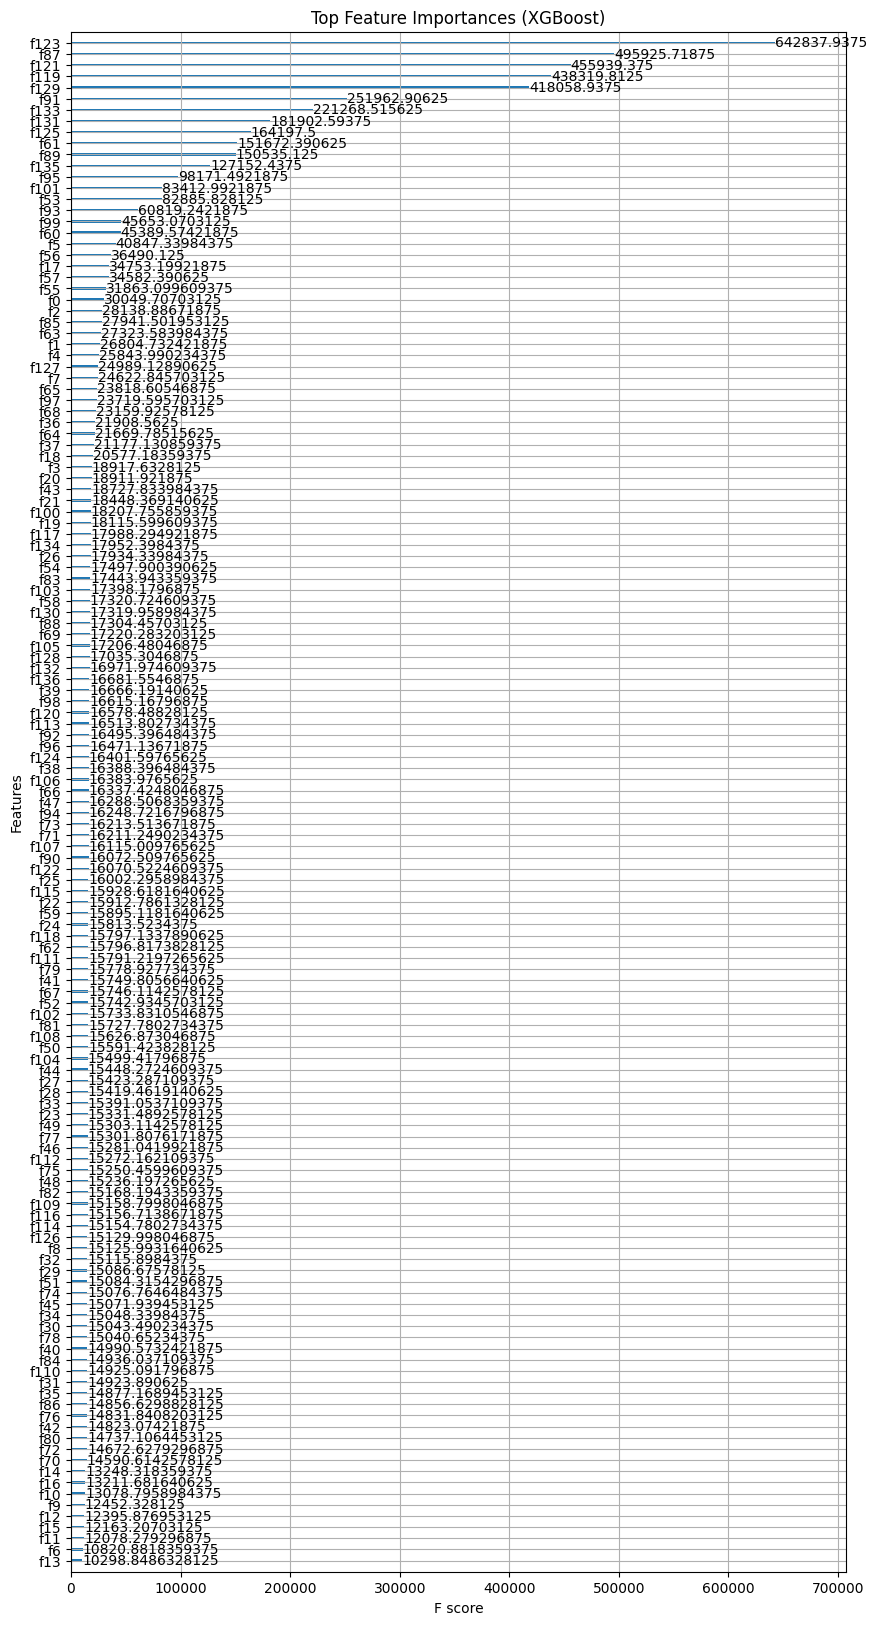

In [19]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, importance_type='gain',ax=ax)
plt.title("Top Feature Importances (XGBoost)")
plt.show()

# Make Submission CSV
We save our test predictions to submission.csv and plot our predictions. 

In [22]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")
sub.Price = pred
sub.to_csv(f"submission_v{VER}.csv",index=False)
sub.head()

,id,Price
0,300000,80.164601
1,300001,81.816371
2,300002,85.859009
3,300003,78.404828
4,300004,79.210748


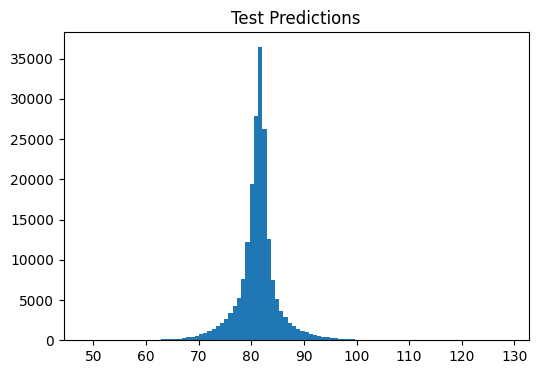

In [23]:
plt.figure(figsize=(6,4))
plt.hist(sub.Price,bins=100)
plt.title("Test Predictions")
plt.show()